# Analysis of Routing Request Profiling Data


This notebook analyzes routing request profiling data from parallel QSim runs and router profiling logs. It loads the data, merges it based on request identifiers, and visualizes the relationships between request durations recorded by QSim and the router.

We see a clear correlation between blocking_recv durations in QSim and the preplanning horizon. There are some activities that have duration = 0. In this case, the former asynchronous requests get synchronous and the qsim waits for the router to respond immediately.

In [1]:
from datetime import datetime
from pathlib import Path

import pandas as pd

from load import discover_runs, read_aggregated_routing

In [2]:
root = Path("/Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4")

runs = discover_runs(root)
print(runs)


NotADirectoryError: /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4

In [3]:
routing_data: dict[str, pd.DataFrame] = {}

for run in runs:
    print(f"Loading routing data for run {run.run_id}")
    data = read_aggregated_routing(run)
    data = data[data["request_uuid_u128"] != 0]
    routing_data[run.run_id] = data

Loading routing data for run sim192_hor1800_w4_r192_10pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim192_hor1800_w4_r192_10pct/instrument/routing_aggregated.parquet
Loading routing data for run sim192_hor600_w4_r192_10pct
Reading parquet:  /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/sim192_hor600_w4_r192_10pct/instrument/routing_aggregated.parquet


In [52]:
routing_data["sim192_hor1800_w4_r192_10pct"].columns.values

array(['target', 'func_name', 'duration_ns', 'sim_time', 'person_id',
       'mode', 'rank', 'run_id', 'sim_cpus', 'horizon', 'worker_threads',
       'router_threads', 'pct', 'process_id', 'timestamp_u128',
       'request_uuid_u128'], dtype=object)

# Load Router Data

In [4]:
def load_routing_profiling_data(
        base_dir: str,
        commit_hash: str,
        pattern: str,
        range_max: int
) -> pd.DataFrame:
    """
    Find directories matching pattern, navigate to commit hash subfolder,
    and load the latest routing profiling CSV file from each.

    Args:
        base_dir: Base directory to search in
        commit_hash: Commit hash subfolder name
        pattern: Directory name pattern (e.g., "experiment")
        range_max: Maximum value in range (searches 0 to range_max inclusive)

    Returns:
        Concatenated DataFrame with all routing profiling data and a "server" column

    Example:
        data = load_routing_profiling_data(
            "/path/to/base",
            "abc123",
            "experiment",
            5
        )
        # Returns: DataFrame with all data and "server" column indicating source
    """
    base_path = Path(base_dir)
    dataframes = []

    # Search for directories matching pattern<number>
    for i in range(range_max + 1):
        dir_name = f"{pattern}{i}"
        target_dir = base_path / dir_name / commit_hash

        if not target_dir.exists() or not target_dir.is_dir():
            continue

        # Find all routing profiling CSV files
        csv_files = list(target_dir.glob("routing-profiling-*.csv"))

        if not csv_files:
            continue

        # Extract dates from filenames and find the latest
        latest_file = None
        latest_datetime = None

        for csv_file in csv_files:
            # Extract datetime from filename: routing-profiling-2026-01-21_14-43-12.csv
            match = re.search(r'routing-profiling-(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2})\.csv', csv_file.name)
            if match:
                date_str = match.group(1)
                try:
                    # Parse the datetime
                    file_datetime = datetime.strptime(date_str, "%Y-%m-%d_%H-%M-%S")

                    if latest_datetime is None or file_datetime > latest_datetime:
                        latest_datetime = file_datetime
                        latest_file = csv_file
                except ValueError:
                    # Skip files with invalid datetime format
                    continue

        # Load the latest file if found
        if latest_file:
            try:
                print(f"Loading {latest_file}")
                df = pd.read_csv(latest_file)
                df['server'] = i  # Add server column with directory number
                dataframes.append(df)
            except Exception as e:
                print(f"Warning: Failed to load {latest_file}: {e}")

    # Concatenate all DataFrames
    if not dataframes:
        return pd.DataFrame()  # Return empty DataFrame if no data found

    return pd.concat(dataframes, ignore_index=True)

In [6]:
import re

router_base = Path("/Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct")

router_data: dict[str, pd.DataFrame] = {}

for run in runs:
    print(run.run_id)

    data = load_routing_profiling_data(base_dir=str(router_base), commit_hash="fc10f2e",
                                       pattern="routing-" + run.run_id + "_server", range_max=24)
    data['request_id'] = data['request_id'].astype(object).apply(int)

    router_data[run.run_id] = data

router_data

sim192_hor1800_w4_r192_10pct
Loading /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-sim192_hor1800_w4_r192_10pct_server0/fc10f2e/routing-profiling-2026-01-21_15-37-15.csv
Loading /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-sim192_hor1800_w4_r192_10pct_server1/fc10f2e/routing-profiling-2026-01-21_15-37-15.csv
Loading /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-sim192_hor1800_w4_r192_10pct_server2/fc10f2e/routing-profiling-2026-01-21_15-37-15.csv
Loading /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-sim192_hor1800_w4_r192_10pct_server3/fc10f2e/routing-profiling-2026-01-21_15-37-15.csv
Loading /Users/paulh/hlrn-cluster/rust-pt-routing/parallel-qsim-berlin/output/v6.4/10pct/routing-sim192_hor1800_w4_r192_10pct_server4/fc10f2e/routing-profiling-2026-01-21_15-37-15.csv
Loading /Users/paulh/hlrn-cluster/rust-pt-routing/p

{'sim192_hor1800_w4_r192_10pct':         thread     now  departure_time          from            to  \
 0           15       0               0   627608831#1    -4557344#2   
 1           21    1898            2498     -71746025   -1120678942   
 2            7    2227            2827  -335396339#0  -335396339#0   
 3            6    2390            2990  -105469688#0  -105469688#0   
 4           14    2612            3212    -150057237    -150057237   
 ...        ...     ...             ...           ...           ...   
 627186      16   91421           91421   717741321#0    -4606156#2   
 627187      13   91835           91835    -284879903    -296669638   
 627188      19   92789           93389     994863622    -858177673   
 627189      17   97915           98515  -323097014#1  -448170245#0   
 627190       8  113240          113240    -837147974    -155594947   
 
                  start  duration_ns  travel_time_s  \
 0       18765612089913     71985091           1012   
 1  

In [7]:
sample_run_id = "sim192_hor600_w4_r192_10pct"

router = router_data[sample_run_id]

qsim = routing_data[sample_run_id]
qsim = qsim[qsim["func_name"] == "blocking_recv"]

# qsim[qsim['request_uuid_u128']==2138593376791811783315487986121543560]

# join on request_uuid_u128 in qsim and request_id in router
merged_df = pd.merge(
    qsim,
    router,
    left_on='request_uuid_u128',
    right_on='request_id',
    how='inner'  # or 'left', 'right', 'outer' depending on your needs
)

# rename duration_ns_x to duration_ns_qsim and duration_ns_y to duration_ns_router
merged_df = merged_df.rename(columns={'duration_ns_x': 'duration_ns_qsim', 'duration_ns_y': 'duration_ns_router'})

merged_df

,target,func_name,duration_ns_qsim,sim_time,person_id,mode,rank,run_id,sim_cpus,horizon,...,thread,now,departure_time,from,to,start,duration_ns_router,travel_time_s,request_id,server
0,rust_qsim::simulation::agents::agent_logic,blocking_recv,2390,5154,berlin_cebf066f,,0,sim192_hor600_w4_r192_10pct,192,600,...,9,4554,5154,1008899214,1008899214,1571520755425804,2887397,0,2138593284811882049340098308117310587,5
1,rust_qsim::simulation::agents::agent_logic,blocking_recv,2450,5749,berlin_84689ad3,,0,sim192_hor600_w4_r192_10pct,192,600,...,23,5149,5749,-4615783#1,-4615783#1,1571520834875580,1900915,0,2138593284907389272093672241711733124,5
2,rust_qsim::simulation::agents::agent_logic,blocking_recv,2790,8257,berlin_32c31f1f,,0,sim192_hor600_w4_r192_10pct,192,600,...,5,7657,8257,-126215416#0,23814654,1571523267310534,1910454,506,2138593285433274034539978927409137976,3
3,rust_qsim::simulation::agents::agent_logic,blocking_recv,1980,9536,berlin_4a7b9600,,0,sim192_hor600_w4_r192_10pct,192,600,...,11,8936,9536,724607626#0,-628661978#1,1571523364127780,1641329,969,2138593285585545600138114196579226414,4
4,rust_qsim::simulation::agents::agent_logic,blocking_recv,2070,9776,berlin_32c31f1f,,0,sim192_hor600_w4_r192_10pct,192,600,...,11,9176,9776,23814654,-126215416#0,1571523402343656,1643803,506,2138593285604889889270050149172093554,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627186,rust_qsim::simulation::agents::agent_logic,blocking_recv,960,76847,bb_1a6334ee,,95,sim192_hor600_w4_r192_10pct,192,600,...,9,76247,76847,25789243,-136387373#0,1571593506882670,407740,260,2138593370383242296706896667451219364,4
627187,rust_qsim::simulation::agents::agent_logic,blocking_recv,615071,77108,bb_1a6334ee,,95,sim192_hor600_w4_r192_10pct,192,600,...,20,77108,77108,-136387373#0,25789243,1571591927198798,429928,260,2138593370820913934580432262427913032,6
627188,rust_qsim::simulation::agents::agent_logic,blocking_recv,2520,78602,bb_f2f927cf,,95,sim192_hor600_w4_r192_10pct,192,600,...,3,78002,78602,-537512220#1,-537512220#1,1571594144158866,8825854,245,2138593371100130600609227246501298095,2
627189,rust_qsim::simulation::agents::agent_logic,blocking_recv,1750,78709,bb_e653ffb9,,95,sim192_hor600_w4_r192_10pct,192,600,...,14,78109,78709,-25325411#1,-1054468019,1571592234452338,406378,1990,2138593371192012506313057426409164260,6


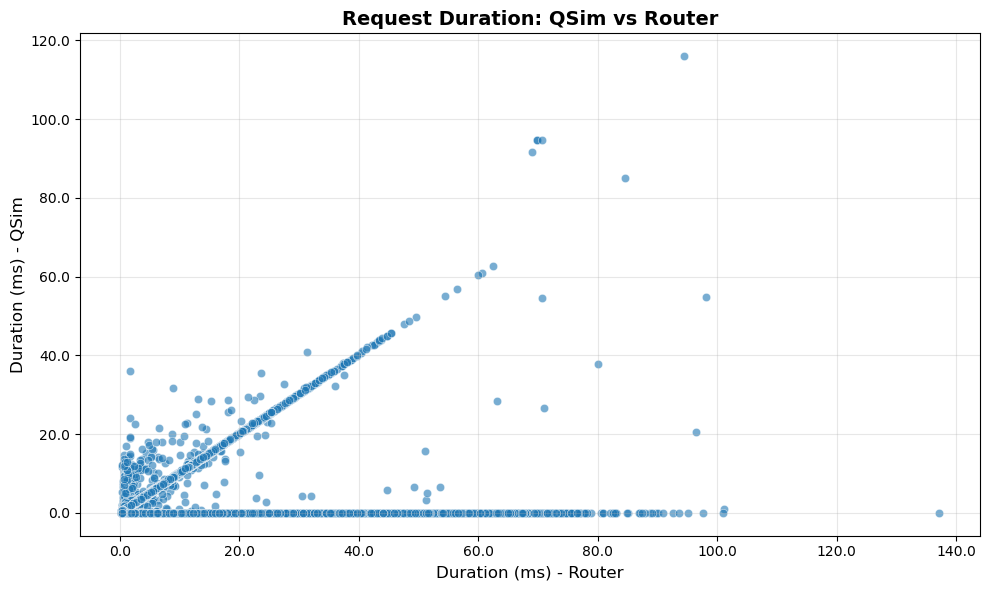

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot with scaled values (ns to ms)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='duration_ns_router', y='duration_ns_qsim', alpha=0.6)

# Scale axes to milliseconds
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x / 1e6:.1f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y / 1e6:.1f}'))

# Add title and labels
plt.title('Request Duration: QSim vs Router', fontsize=14, fontweight='bold')
plt.xlabel('Duration (ms) - Router', fontsize=12)
plt.ylabel('Duration (ms) - QSim', fontsize=12)

# Show grid for easier reading
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

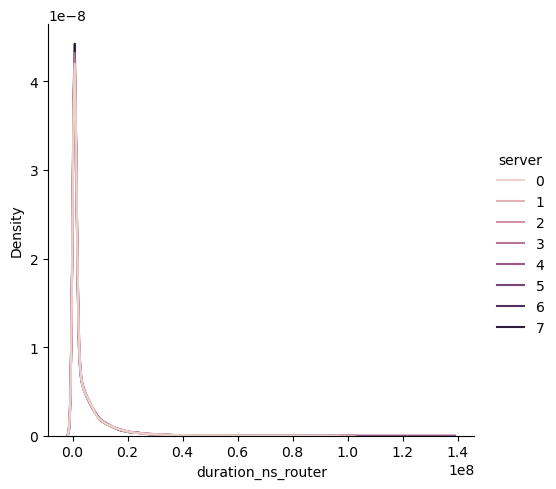

In [9]:
# plot distribution of duration_ns_qsim and duration_ns_router with seaborn into one plot
sns.displot(merged_df, x="duration_ns_router", hue="server", kind="kde")


# Group QSim data for the insights

In [10]:
# Pivot the data to get duration_ns and sim_time for each func_name
# result = routing_data[sample_run_id].pivot_table(
#     index='request_uuid_u128',
#     columns='func_name',
#     values=['duration_ns', 'sim_time'],
#     aggfunc='min'
#     # aggfunc='first'  # Use 'first' since there should be exactly one row per func_name
# )
#
# # Flatten the multi-level column names
# result.columns = [f'{col[1]}_{col[0]}' for col in result.columns]
#
# # Reset index to make request_uuid_u128 a regular column
# result = result.reset_index()
#
# result

In [11]:
funcs = [
    "call_router",
    "blocking_recv",
    "replace_next_trip",
    "replace_route",
]

routing_data[sample_run_id] = routing_data[sample_run_id][routing_data[sample_run_id]["request_uuid_u128"] != 0]

df4 = routing_data[sample_run_id][routing_data[sample_run_id]["func_name"].isin(funcs)]

counts = (
    df4.groupby(["request_uuid_u128", "func_name"])
    .size()
    .unstack(fill_value=0)
)

# Check that every UUID has exactly one of each function
bad = counts[(counts != 1).any(axis=1)]
if not bad.empty:
    raise ValueError(
        f"Some request_uuid_u128 do not have exactly one row per func_name:\n{bad}"
    )

pivot = (
    df4
    .set_index(["request_uuid_u128", "func_name"])
    [["duration_ns", "sim_time"]]
    .unstack("func_name")
)

pivot.columns = [
    f"{metric}_{func}" for metric, func in pivot.columns
]

wide_qsim = pivot.reset_index()

wide_qsim["real_horizon"] = wide_qsim['sim_time_replace_route'] - wide_qsim['sim_time_call_router']

wide_qsim

,request_uuid_u128,duration_ns_blocking_recv,duration_ns_call_router,duration_ns_replace_next_trip,duration_ns_replace_route,sim_time_blocking_recv,sim_time_call_router,sim_time_replace_next_trip,sim_time_replace_route,real_horizon
0,2138593282210281674997893979802154368,94775385,190820,98241,94996756,0,0,0,0,0
1,2138593282210281674997894053981266068,94803275,130090,68941,94898566,0,0,0,0,0
2,2138593282210281674997894131780689138,4970,148700,113090,127430,214,0,214,214,214
3,2138593282210281674997894246200616337,94715755,14770,94021,94887486,0,0,0,0,0
4,2138593283960803863590960822685789180,91693401,27240,23310,91732341,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
627186,2138593375908066404561358773064091664,1336672,21510,4290,1344922,116387,116387,116387,116387,0
627187,2138593375922579988571010663423434184,4620,24000,6210,17980,117201,116601,117201,117201,600
627188,2138593376177668667182300683644828243,1318312,18550,3370,1325362,120983,120983,120983,120983,0
627189,2138593376203060776103436864598837456,1082492,21390,3400,1089972,121373,121373,121373,121373,0


In [12]:
merged_df_wide = pd.merge(
    wide_qsim,
    router,
    left_on='request_uuid_u128',
    right_on='request_id',
    how='inner'  # or 'left', 'right', 'outer' depending on your needs
)

merged_df_wide

,request_uuid_u128,duration_ns_blocking_recv,duration_ns_call_router,duration_ns_replace_next_trip,duration_ns_replace_route,sim_time_blocking_recv,sim_time_call_router,sim_time_replace_next_trip,sim_time_replace_route,real_horizon,thread,now,departure_time,from,to,start,duration_ns,travel_time_s,request_id,server
0,2138593282210281674997893979802154368,94775385,190820,98241,94996756,0,0,0,0,0,5,0,0,-21603801,4689342,1571520636395086,70726402,452,2138593282210281674997893979802154368,2
1,2138593282210281674997894053981266068,94803275,130090,68941,94898566,0,0,0,0,0,11,0,0,-8149650,-146174357,1571520614457668,69763251,1023,2138593282210281674997894053981266068,0
2,2138593282210281674997894131780689138,4970,148700,113090,127430,214,0,214,214,214,7,0,214,-1101010197,-182600492#0,2159893481028738,74752637,943,2138593282210281674997894131780689138,1
3,2138593282210281674997894246200616337,94715755,14770,94021,94887486,0,0,0,0,0,5,0,0,627608831#1,-4557344#2,1571520621457169,69866191,1012,2138593282210281674997894246200616337,3
4,2138593283960803863590960822685789180,91693401,27240,23310,91732341,0,0,0,0,0,1,0,0,-34822334#0,-1122765058#0,1571522038434903,68980647,288,2138593283960803863590960822685789180,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627186,2138593375908066404561358773064091664,1336672,21510,4290,1344922,116387,116387,116387,116387,0,11,116387,116387,-131578001,-989737330,1571598120929918,639540,264,2138593375908066404561358773064091664,2
627187,2138593375922579988571010663423434184,4620,24000,6210,17980,117201,116601,117201,117201,600,2,116601,117201,-999358413,508614986#0,1571598118325708,382461,113673,2138593375922579988571010663423434184,3
627188,2138593376177668667182300683644828243,1318312,18550,3370,1325362,120983,120983,120983,120983,0,15,120983,120983,-188866873#2,-19064220#4,1571598300026682,509601,389,2138593376177668667182300683644828243,4
627189,2138593376203060776103436864598837456,1082492,21390,3400,1089972,121373,121373,121373,121373,0,23,121373,121373,-19064220#4,-188866873#2,1571596351681816,542821,389,2138593376203060776103436864598837456,5


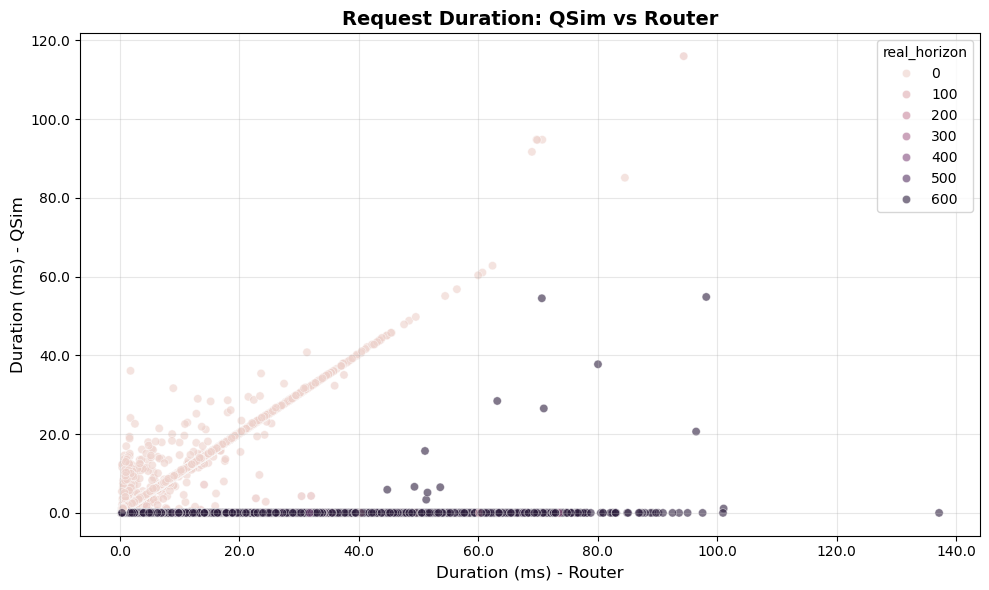

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot with scaled values (ns to ms)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df_wide, x='duration_ns', y='duration_ns_blocking_recv', hue="real_horizon", alpha=0.6)

# Scale axes to milliseconds
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x / 1e6:.1f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y / 1e6:.1f}'))

# Add title and labels
plt.title('Request Duration: QSim vs Router', fontsize=14, fontweight='bold')
plt.xlabel('Duration (ms) - Router', fontsize=12)
plt.ylabel('Duration (ms) - QSim', fontsize=12)

# Show grid for easier reading
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

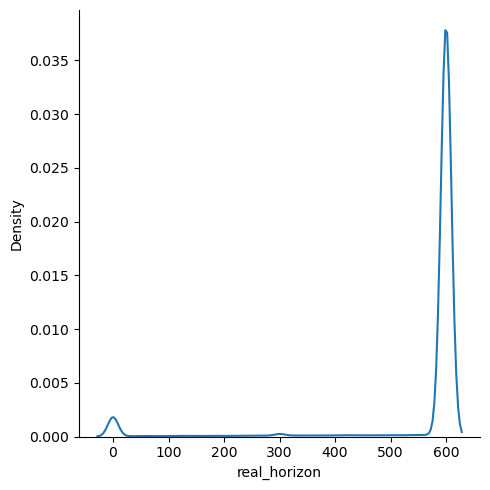

In [19]:
# plot distribution of real_horizon
sns.displot(merged_df_wide, x="real_horizon", kind="kde")


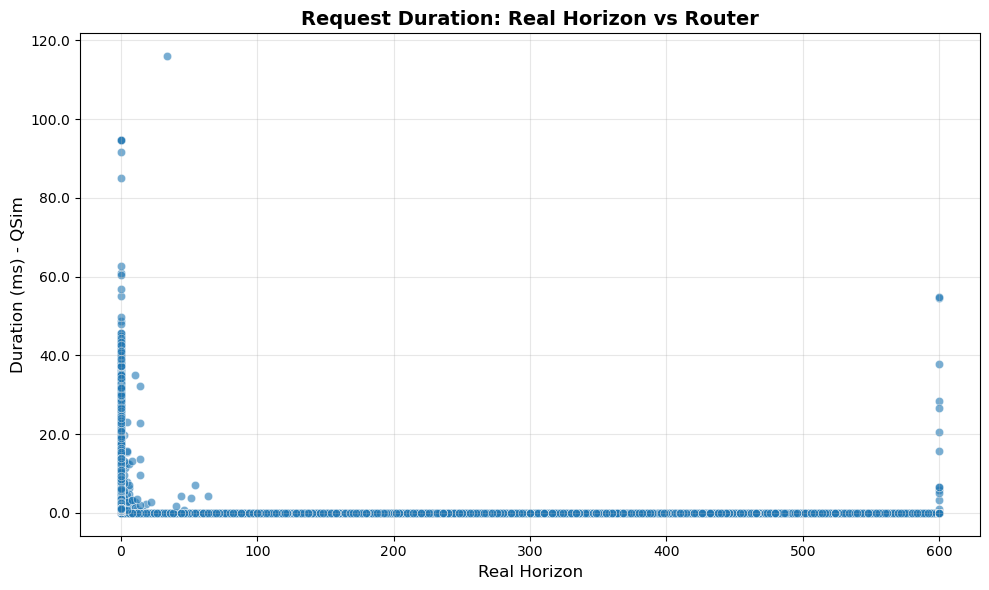

In [20]:
# Create scatter plot with scaled values (ns to ms)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df_wide, x='real_horizon', y='duration_ns_blocking_recv', alpha=0.6)

# Scale axes to milliseconds
ax = plt.gca()
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y / 1e6:.1f}'))

# Add title and labels
plt.title('Request Duration: Real Horizon vs Router', fontsize=14, fontweight='bold')
plt.xlabel('Real Horizon', fontsize=12)
plt.ylabel('Duration (ms) - QSim', fontsize=12)

# Show grid for easier reading
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Text(9.444444444444445, 0.5, 'Density')

<Figure size 1000x600 with 0 Axes>

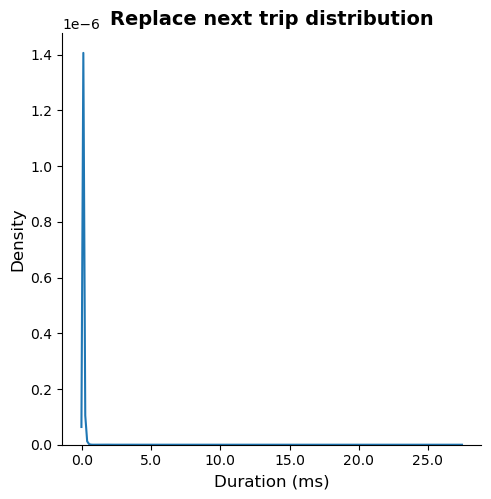

In [31]:
# plot distribution of duration_ns_replace_next_trip
# scale by 1/1e6 before
plt.figure(figsize=(10, 6))
sns.displot(merged_df_wide, x="duration_ns_replace_next_trip", kind="kde")
ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x / 1e6:.1f}'))
# ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, p: f'{y/1e6:.1f}'))

plt.title('Replace next trip distribution', fontsize=14, fontweight='bold')
plt.xlabel('Duration (ms)', fontsize=12)
plt.ylabel('Density', fontsize=12)
